In [ ]:
%pip install numpy matplotlib scipy ipywidgets control IPython sympy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


In [9]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')


# Time Delay
A time delay refers to the phenomenon where there's a delay between the input to the system and its corresponding output response. This delay can occur due to various reasons, such as sensor response time, communication latency in a controller implemented within a computer, or physical delays, like water traveling inside a pipe when the shower is turned on.

We want to account for the effects of time delays. The time delay operator, which transforms an input signal $ u(t) $ into a delayed output $ y(t) = u(t-T) $ with a delay of $ T $ seconds, is represented in the Laplace domain as:
$$e^{-sT}$$  

### Example
Consider a first-order system of the form $ G(s) = \frac{5}{s+3} $. We want to add a time delay of 4 seconds. The new transfer function becomes:
$$G(s) = \frac{5}{s+3}e^{-4s}$$

The time delay operator is a linear operator, but the resulting transfer function is not rational, which means we cannot apply the root-locus method. Additionally, a time delay can make a system unstable.


In [ ]:
def plot_step_response_delay(wn, zeta, delay):

    num = [wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = ct.TransferFunction(num, den)

    delay_approx = ct.pade(delay, 10)
    delay_tf = ct.TransferFunction(*delay_approx)
    sys_delayed = sys * delay_tf

    time = np.linspace(0, 20, 500)

    t, y_no_delay = ct.step_response(sys, T=time)  # Without delay
    t, y_with_delay = ct.step_response(sys_delayed, T=time)  # With delay

    plt.figure(figsize=(10, 6))
    plt.plot(t, y_no_delay, label=f'No Delay')
    plt.plot(t, y_with_delay, label=f'With Delay={delay}s', linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Second Order System Step Response with and without Time Delay')
    plt.grid(True)
    plt.legend()
    plt.show()

wn_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='ωn')
zeta_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='ζ')
delay_slider = widgets.FloatSlider(value=0.0, min=0.0, max=2.0, step=0.01, description='Delay')

interactive_plot = widgets.interactive(plot_step_response_delay, wn=wn_slider, zeta=zeta_slider, delay=delay_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='ωn', max=5.0, min=0.1), FloatSlider(value=0.5, descr…

## Effect of Time Delay on Bode and Polar Plot

# Gain and Phase Margin

The distance from the Nyquist plot to the -1 point is a measure of system robustness or how far our system is from instability. On the Bode plot, we measure this robustness using the **gain margin** and **phase margin**.

For a system to be stable, the magnitude plot should be below 0 dB when the phase plot crosses -180°.

* The gain crossover frequency, $ \omega_c $, is the frequency where the Bode plot crosses 0 dB, that is, where $ \left| L(j\omega_c) \right| = 1 $.
* The phase crossover frequency, $ \omega_{pc} $, is the frequency where the Bode plot crosses -180°, that is, where $ \angle L(j\omega_{pc}) = -180° $.

The **gain margin** is the distance from the current magnitude to 0 dB at the phase crossover frequency, $ \omega_{pc} $. Similarly, the **phase margin** is the distance between the current phase and -180° at the gain crossover frequency, $ \omega_c $.

**Remember:** Gain and phase margin can only be used if the system is open-loop stable and has minimum phase.

### Visualisation
Try calculating the gain and phase margin by hand and then try to validate your calculation with the interactive plot.


In [22]:
def bode_plot_with_margins(num, den):

    sys = ct.TransferFunction(num, den)
    gm, pm, wcg, wcp = ct.margin(sys)

    mag, phase, omega = ct.bode_plot(sys, dB=True, deg=True, plot=False)
    mag = 20 * np.log10(mag)
    phase = np.degrees(phase)

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.semilogx(omega, mag, label='Magnitude (dB)')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcp):
      plt.plot(wcp, 0, 'ro', label=f'Gain Crossover @ {wcp:.2f} rad/s')
    if gm != float('inf'):
        plt.vlines(wcg, 0, -20 * np.log10(gm), color='red', linestyle=':', label=f'Gain Margin = {20 * np.log10(gm):.2f} dB')

    plt.ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    plt.subplot(2, 1, 2)
    plt.semilogx(omega, phase, label='Phase (degrees)')
    plt.axhline(-180, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcg):
      plt.plot(wcg, -180, 'bo', label=f'Phase Crossover @ {wcg:.2f} rad/s')
    if pm != float('inf'):
        plt.vlines(wcp, -180, -180 + pm, color='red', linestyle=':', label=f'Phase Margin = {pm:.2f} degrees')

    plt.ylabel('Phase (degrees)')
    plt.xlabel('Frequency (rad/s)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    print("Gain Margin (dB):", 20 * np.log10(gm) if gm > 0 else 'Infinity')
    print("Phase Margin (degrees):", pm)
    print("Gain Crossover Frequency (rad/s):", wcp)
    print("Phase Crossover Frequency (rad/s):", wcg)

    plt.tight_layout()
    plt.show()

def update_bode_plot(b):
    clear_output(wait=True)
    display(widgets.VBox([numerator_text, denominator_text, plot_button]))

    try:
        num = [float(x) for x in numerator_text.value.split(',')]
        den = [float(x) for x in denominator_text.value.split(',')]
        bode_plot_with_margins(num, den)
    except ValueError:
        print("Please enter valid coefficients separated by commas.")

numerator_text = widgets.Text(value='100', description='Numerator:', placeholder='e.g., 10,4')
denominator_text = widgets.Text(value='1,10,100', description='Denominator:', placeholder='e.g., 12,30,50')
plot_button = widgets.Button(description="Plot Bode")

plot_button.on_click(update_bode_plot)

# Display the widgets
display(widgets.VBox([numerator_text, denominator_text, plot_button]))


# Time Delay in Frequency Response

Since the magnitude of the time delay is $ \left| e^{j\omega T} \right| = 1 $ and the phase is $ \angle(e^{-j\omega T}) = -\omega T $, we see that the time delay only influences the phase in the frequency domain.

In the complex plane, the polar plot of $e^{-jwT}$ forms a circle with unit radius. The Bode magnitude plot remains a straight horizontal line at 1 (0 dB), as time delay does not affect the magnitude.

For our open-loop Transfer function this means:<br>
$$L'(s)=e^{-sT}L(s)$$<br>

$$\left|L'(jw) \right|=\left|L(jw) \right|$$<br>

$$\angle L'(jw)=\angle L(jw)-wT$$<br>

For the closed loop system, the time delay rotates the polar plot clockwise and changes in the bode plot the phase margin of the system changes:
$$ \phi_{m,t} = \phi_{0} - \omega_c T $$, where $\phi_{m,t}$ is our new phase margin after the time delay and $\phi_{0}$ is the phase margin without a time delay. We can clearly see that the time delay reduces the phase margin.

### Visualisation
Try adjusting the time delay and observe how the margins change.
Notice that the system can get unstable (negative margins) when the time delay is to high

Gain Margin (dB): -0.8832548623283031
Phase Margin (degrees): 152.06194653672367
Gain Crossover Frequency (rad/s): 10.000000000000028
Phase Crossover Frequency (rad/s): 4.931050240136267


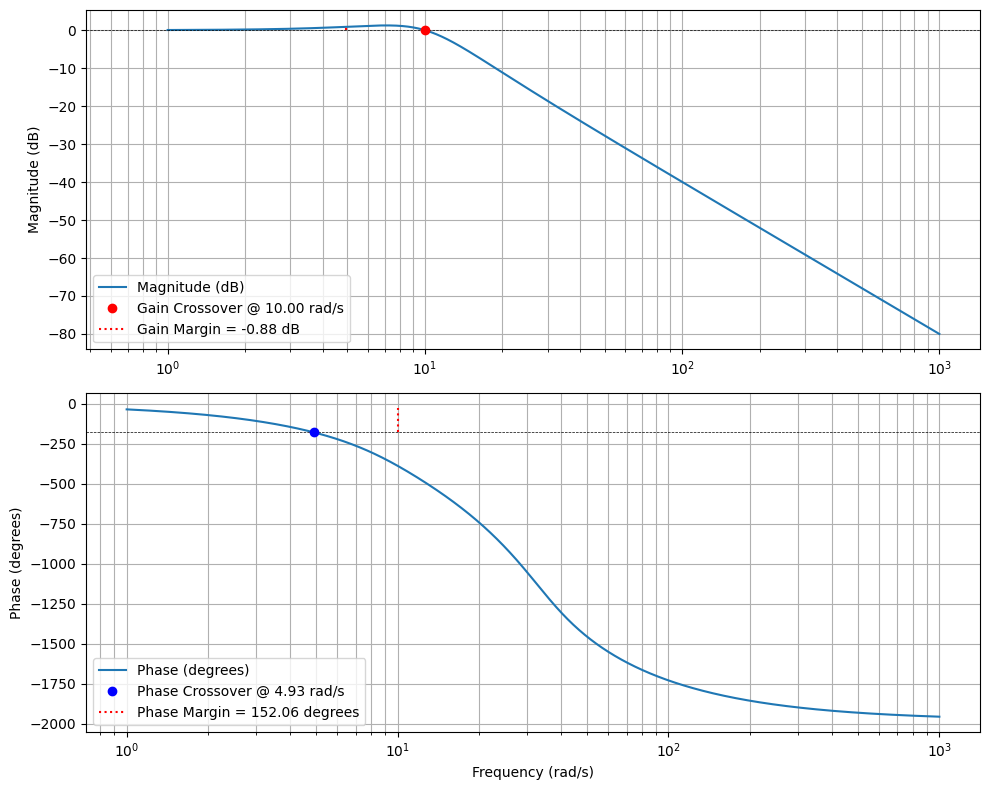

In [11]:
def bode_plot_with_margins_delay(num, den, delay_num=None, delay_den=None):
    if delay_num is not None and delay_den is not None:
        delay_sys = ct.TransferFunction(delay_num, delay_den)
        sys = ct.series(ct.TransferFunction(num, den), delay_sys)
    else:
        sys = ct.TransferFunction(num, den)

    gm, pm, wcg, wcp = ct.margin(sys)

    mag_d, phase_d, omega_d = ct.bode_plot(delay_sys, dB=True, deg=True, plot=False)
    mag_d = 20 * np.log10(mag_d)
    phase_d = np.degrees(phase_d)


    mag, phase, omega = ct.bode_plot(sys, dB=True, deg=True, plot=False)
    mag = 20 * np.log10(mag)
    phase = np.degrees(phase)

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.semilogx(omega, mag, label='Magnitude (dB)')
    #plt.semilogx(omega_d, mag_d, label='Magnitude (dB)')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcp):
        plt.plot(wcp, 0, 'ro', label=f'Gain Crossover @ {wcp:.2f} rad/s')
    if gm != float('inf'):
        plt.vlines(wcg, 0, -20 * np.log10(gm), color='red', linestyle=':', label=f'Gain Margin = {20 * np.log10(gm):.2f} dB')

    plt.ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    plt.subplot(2, 1, 2)
    plt.semilogx(omega, phase, label='Phase (degrees)')
    #plt.semilogx(omega_d, phase_d, label='Phase (degrees)')

    plt.axhline(-180, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcg):
        plt.plot(wcg, -180, 'bo', label=f'Phase Crossover @ {wcg:.2f} rad/s')
    if pm != float('inf'):
        plt.vlines(wcp, -180, -180 + pm, color='red', linestyle=':', label=f'Phase Margin = {pm:.2f} degrees')

    plt.ylabel('Phase (degrees)')
    plt.xlabel('Frequency (rad/s)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    print("Gain Margin (dB):", 20 * np.log10(gm) if gm > 0 else 'Infinity')
    print("Phase Margin (degrees):", pm)
    print("Gain Crossover Frequency (rad/s):", wcp)
    print("Phase Crossover Frequency (rad/s):", wcg)

    plt.tight_layout()
    plt.show()

def update_bode_plot(b):
    clear_output(wait=True)
    display(widgets.VBox([numerator_text, denominator_text, delay_slider, plot_button]))

    try:
        num = [float(x) for x in numerator_text.value.split(',')]
        den = [float(x) for x in denominator_text.value.split(',')]
        delay = delay_slider.value

        delay_num, delay_den = ct.pade(delay, n=10)
        bode_plot_with_margins_delay(num, den, delay_num, delay_den)
    except ValueError:
        print("Please enter valid coefficients separated by commas.")

numerator_text = widgets.Text(value='100', description='Numerator:', placeholder='e.g., 10,4')
denominator_text = widgets.Text(value='1,10,100', description='Denominator:', placeholder='e.g., 12,30,50')

delay_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=2.0,
    step=0.01,
    description='Time Delay (s):',
    continuous_update=False
)

plot_button = widgets.Button(description="Plot Bode")

plot_button.on_click(update_bode_plot)

display(widgets.VBox([numerator_text, denominator_text, delay_slider, plot_button]))


# Frequency-domain specifications

We are already familiar with two frequency-domain specifications: the gain and phase margins. There are several other important specifications we can use to categorize our system.

**Low Frequencies**  
Commands and disturbances usually occur at low frequencies, up to $ 10 $ Hz.  
Good command tracking and disturbance rejection mean ensuring a low sensitivity function $ |S(j\omega)| < 1 $ or having the complementary sensitivity function $ |T(j\omega)| \approx 1 $.

**High Frequencies**  
Noise typically occurs at high frequencies, above $ 100 $ Hz. To reduce the effect of the noise on the system output, $ |T(j\omega)| $ should be small.

**Bandwidth**  
The bandwidth is the maximum frequency $ \omega $ for which our closed-loop system satisfies:
$$ |T(j\omega)| > \frac{1}{\sqrt{2}} $$
or
$$ |T(j\omega)| > -3 \text{ dB} $$

The closed-loop bandwidth is approximately the open-loop crossover frequency and refers to the range of frequencies over which a system can respond effectively. The bandwidth can be viewed as the system's ability to follow a signal or react to inputs in the frequency domain.

A wide bandwidth allows the system to respond to high-frequency components of the input, but it may also amplify high-frequency noise or undesirable signals, potentially leading to noise issues in the system.

Conversely, a narrow bandwidth reduces noise sensitivity but also limits the system’s ability to respond to high-frequency signals.


# Bode Obstacle Course

The Bode obstacle course can be used to design a control system's open-loop frequency response to meet certain performance requirements in the closed-loop system. It describes how specific requirements on tracking, disturbance rejection, and noise rejection manifest as constraints or "obstacles" in the Bode plot of the open-loop transfer function $ L(j\omega) $.

Obstacles on the Bode plot represent frequency regions where the open-loop gain $ |L(j\omega)| $ must meet specific values.

**Low-frequency Obstacle:**  
To achieve good tracking and disturbance rejection, the sensitivity function $ \left| S(j\omega) \right| = \frac{1}{\left| 1 + L(j\omega) \right|} $ should be small at low frequencies. This requires $ |L(j\omega)| $ to be large in the low-frequency range.  
This appears as an obstacle where the open-loop gain $ |L(j\omega)| $ must be higher than a threshold $ |W_1(j\omega)| $ at low frequencies.

**High-frequency Obstacle:**  
To suppress high-frequency noise, the complementary sensitivity function $ \left| T(j\omega) \right| = \frac{L(j\omega)}{\left| 1 + L(j\omega) \right|} $ should be small at high frequencies. This requires $ |L(j\omega)| $ to be small in the high-frequency range.  
This appears as an obstacle where the open-loop gain $ |L(j\omega)| $ must be lower than a threshold $ |W_2(j\omega)^{-1}| $ at high frequencies.

$ |L(j\omega)| $ should be:

* At low frequencies high enough to satisfy the tracking and disturbance constraints.
* At high frequencies low enough to attenuate noise effectively.
